In [26]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [27]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3, 4, 5, 6, 7]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')


In [28]:
# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')
init_df

,open,high,low,close,adjclose,volume,ticker
2021-03-29,101.108002,102.460503,100.272499,102.289497,102.289497,26492000,GOOGL
2021-03-30,102.649002,103.133499,101.807503,102.323502,102.323502,27312000,GOOGL
2021-03-31,102.720001,104.313004,102.349998,103.125999,103.125999,42570000,GOOGL
2021-04-01,104.612503,106.787498,104.571503,106.488998,106.488998,39880000,GOOGL
2021-04-05,107.357498,111.449501,107.260498,110.947998,110.947998,48510000,GOOGL
...,...,...,...,...,...,...,...
2024-03-27,151.179993,151.639999,148.899994,150.869995,150.869995,22879200,GOOGL
2024-03-28,150.850006,151.429993,150.169998,150.929993,150.929993,24485400,GOOGL
2024-04-01,150.690002,155.740005,150.610001,155.490005,155.490005,31730800,GOOGL
2024-04-02,153.500000,154.699997,152.149994,154.559998,154.559998,24586000,GOOGL


In [29]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index
init_df

,close,date
2021-03-29,102.289497,2021-03-29
2021-03-30,102.323502,2021-03-30
2021-03-31,103.125999,2021-03-31
2021-04-01,106.488998,2021-04-01
2021-04-05,110.947998,2021-04-05
...,...,...
2024-03-27,150.869995,2024-03-27
2024-03-28,150.929993,2024-03-28
2024-04-01,155.490005,2024-04-01
2024-04-02,154.559998,2024-04-02


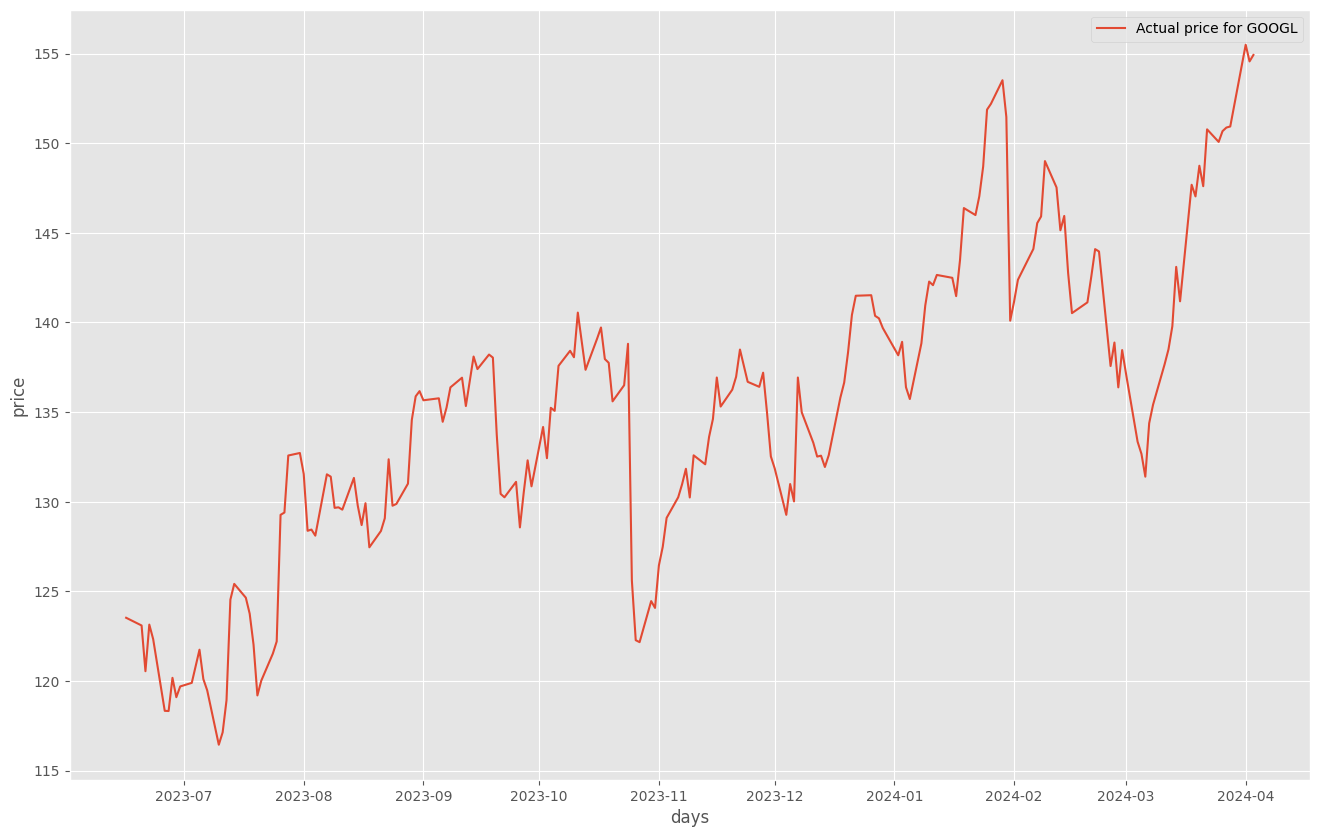

In [30]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [31]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))
init_df

,close,date
2021-03-29,0.261719,2021-03-29
2021-03-30,0.262191,2021-03-30
2021-03-31,0.273328,2021-03-31
2021-04-01,0.319997,2021-04-01
2021-04-05,0.381876,2021-04-05
...,...,...
2024-03-27,0.935887,2024-03-27
2024-03-28,0.936719,2024-03-28
2024-04-01,1.000000,2024-04-01
2024-04-02,0.987094,2024-04-02


In [32]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['close'].shift(-days)
  last_sequence = np.array(df[['close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [33]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [34]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80


/Users/bradymitchelmore/Documents/Code/stock-prediction/stockml/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0046 - loss: 0.0533
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 5.2289e-04 - loss: 0.0073
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 4.9308e-04 - loss: 0.0087
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0046 - loss: 0.0052
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0012 - loss: 0.0059    
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0023 - loss: 0.0045
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0051 - loss: 0.0044
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0012 - loss: 0.0048
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 6.1892e-04 - loss: 0.0043
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 7.4037e-04 - loss: 0.0038
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0047 - loss: 0.0036
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Epoch 1/80


/Users/bradymitchelmore/Documents/Code/stock-prediction/stockml/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0028 - loss: 0.0545
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0037 - loss: 0.0078
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0021 - loss: 0.0063
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0029 - loss: 0.0064
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0018 - loss: 0.0056
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0028 - loss: 0.0057
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0046 - loss: 0.0063
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0053 - loss: 0.0058
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0043 - loss: 0.0045
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 9.3903e-04 - loss: 0.0051
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0021 - loss: 0.0045
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0034 - loss: 0.0

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Epoch 1/80


/Users/bradymitchelmore/Documents/Code/stock-prediction/stockml/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0021 - loss: 0.0596
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0017 - loss: 0.0080
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0010 - loss: 0.0074    
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0022 - loss: 0.0088
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0025 - loss: 0.0079
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0011 - loss: 0.0061    
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0036 - loss: 0.0066
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0011 - loss: 0.0055  
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 9.0926e-04 - loss: 0.0060
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0026 - loss: 0.0057
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0018 - loss: 0.0052
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 6.8523e-

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Epoch 1/80


/Users/bradymitchelmore/Documents/Code/stock-prediction/stockml/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0027 - loss: 0.0621
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0016 - loss: 0.0087
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0028 - loss: 0.0088
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0016 - loss: 0.0081
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0038 - loss: 0.0076
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0033 - loss: 0.0071
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 3.9802e-04 - loss: 0.0077
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0011 - loss: 0.0079  
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0032 - loss: 0.0074
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0067 - loss: 0.0066
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0068 - loss: 0.0066
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0068 - loss: 0

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Epoch 1/80


/Users/bradymitchelmore/Documents/Code/stock-prediction/stockml/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0029 - loss: 0.0732
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0029 - loss: 0.0102
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0016 - loss: 0.0087
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0068 - loss: 0.0092
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 8.6790e-04 - loss: 0.0089
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0029 - loss: 0.0091
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0022 - loss: 0.0074
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0018 - loss: 0.0091
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0024 - loss: 0.0074
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0043 - loss: 0.0071
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 9.5868e-04 - loss: 0.0081
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0022 - loss:

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Epoch 1/80


/Users/bradymitchelmore/Documents/Code/stock-prediction/stockml/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0037 - loss: 0.0674
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0026 - loss: 0.0104
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0057 - loss: 0.0092
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0016 - loss: 0.0098
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 8.1496e-04 - loss: 0.0095
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0012 - loss: 0.0091  
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0019 - loss: 0.0081
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0043 - loss: 0.0088
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0016 - loss: 0.0079
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0043 - loss: 0.0081
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0024 - loss: 0.0089
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0017 - loss: 0

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Epoch 1/80


/Users/bradymitchelmore/Documents/Code/stock-prediction/stockml/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0031 - loss: 0.0700
Epoch 2/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0060 - loss: 0.0123
Epoch 3/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0076 - loss: 0.0120
Epoch 4/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0027 - loss: 0.0111
Epoch 5/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0028 - loss: 0.0114
Epoch 6/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0016 - loss: 0.0096
Epoch 7/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0011 - loss: 0.0100  
Epoch 8/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0060 - loss: 0.0097
Epoch 9/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0011 - loss: 0.0084    
Epoch 10/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0016 - loss: 0.0090
Epoch 11/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0057 - loss: 0.0097
Epoch 12/80
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0026 - loss: 0

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 7, 60)          │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 7, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 120)            │        86,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 20)             │         2,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,605 (1.19 MB)

 Trainable params: 104,201 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 208,404 (814.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


In [35]:
copy_df = init_df.copy()
copy_df['close'] = scaler.inverse_transform(np.expand_dims(copy_df['close'].values, axis=1))

In [36]:
y_predicted = model.predict(x_train)
y_predicted.shape

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(746, 1)

In [37]:
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
y_predicted_transformed

array([111.19864 , 112.25353 , 113.277336, 113.27426 , 113.381714,
       113.15526 , 113.99542 , 114.538765, 114.98716 , 114.99204 ,
       114.94169 , 114.30689 , 114.96809 , 115.707214, 115.71671 ,
       117.20572 , 118.96919 , 119.13729 , 118.8916  , 117.88687 ,
       117.39908 , 117.67052 , 118.19919 , 117.164856, 115.9328  ,
       113.55811 , 112.66931 , 113.4559  , 114.341896, 114.26086 ,
       114.3378  , 115.217735, 115.53241 , 117.18315 , 118.29436 ,
       119.28537 , 119.47577 , 119.3974  , 119.86391 , 119.95316 ,
       119.44068 , 120.11893 , 120.79293 , 121.107735, 121.4782  ,
       122.28587 , 122.68424 , 123.30671 , 123.22278 , 122.8527  ,
       123.04273 , 122.47854 , 122.82717 , 123.315094, 123.50899 ,
       123.77381 , 123.941795, 124.03886 , 123.995   , 123.868454,
       123.93987 , 125.19926 , 126.37218 , 127.14882 , 126.98027 ,
       127.045975, 127.70886 , 128.26474 , 128.91829 , 128.78156 ,
       128.65773 , 127.623886, 127.65969 , 128.27217 , 128.994

In [38]:
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-7:], axis=1))
first_seq, last_seq

(array([[114.13749695],
        [114.48799896],
        [113.95050049],
        [113.91750336],
        [112.62599945],
        [114.99649811]]),
 array([[150.07000732],
        [150.66999817],
        [150.86999512],
        [150.92999268],
        [155.49000549],
        [154.55999756],
        [154.91999817]]))

In [39]:
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed.shape

(752,)

In [40]:
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
y_predicted_transformed.shape

(759,)

In [41]:
# Execute model for the whole history range
copy_df[f'predicted_close'] = y_predicted_transformed

In [42]:
copy_df

,close,date,predicted_close
2021-03-29,102.289497,2021-03-29,114.137497
2021-03-30,102.323502,2021-03-30,114.487999
2021-03-31,103.125999,2021-03-31,113.950500
2021-04-01,106.488998,2021-04-01,113.917503
2021-04-05,110.947998,2021-04-05,112.625999
...,...,...,...
2024-03-27,150.869995,2024-03-27,150.869995
2024-03-28,150.929993,2024-03-28,150.929993
2024-04-01,155.490005,2024-04-01,155.490005
2024-04-02,154.559998,2024-04-02,154.559998


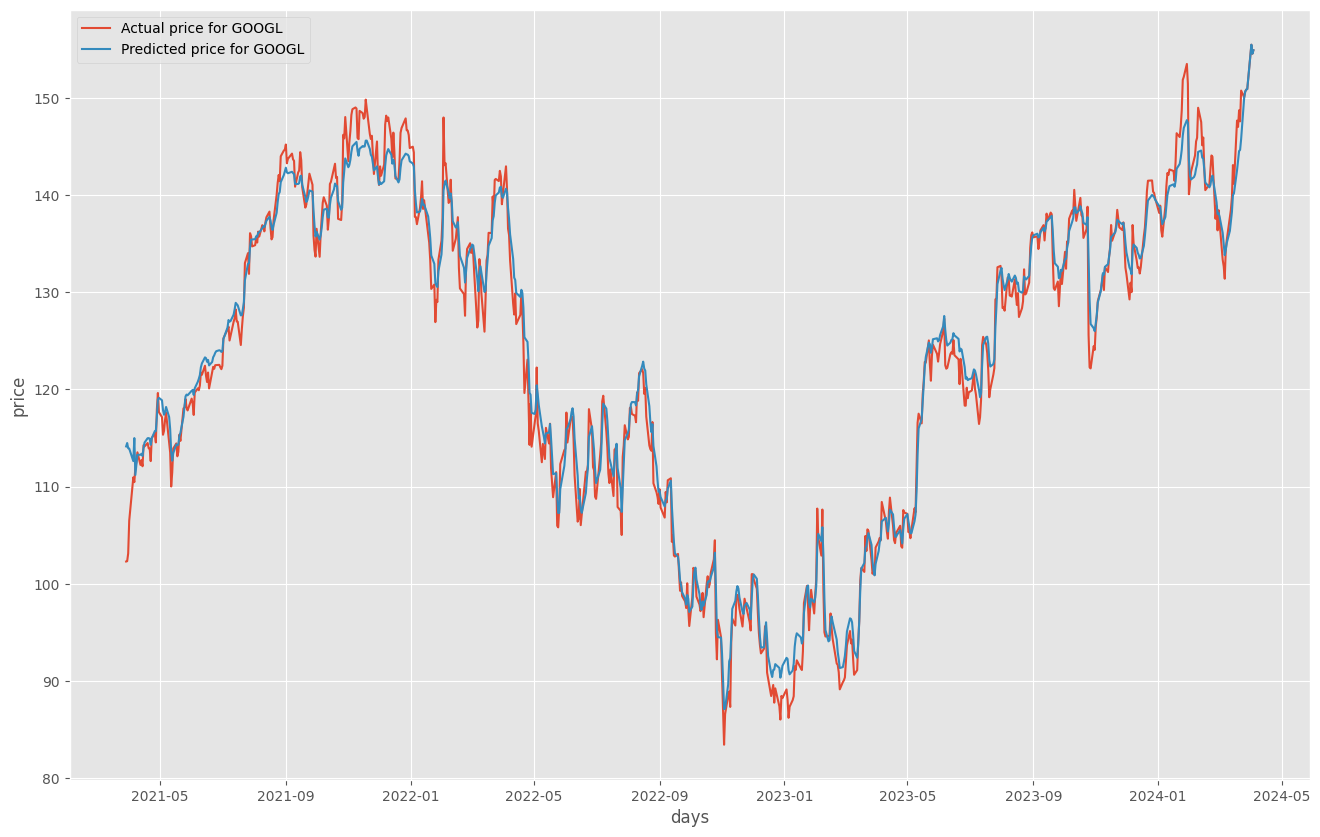

In [44]:
# plot the close vs predicted_close in given data range
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'])
plt.plot(copy_df['predicted_close'])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}', f'Predicted price for {STOCK}'])

In [47]:
copy_df.tail(10)

,close,date,predicted_close
2024-03-20,148.740005,2024-03-20,144.543732
2024-03-21,147.600006,2024-03-21,144.663742
2024-03-22,150.770004,2024-03-22,145.773865
2024-03-25,150.070007,2024-03-25,150.070007
2024-03-26,150.669998,2024-03-26,150.669998
2024-03-27,150.869995,2024-03-27,150.869995
2024-03-28,150.929993,2024-03-28,150.929993
2024-04-01,155.490005,2024-04-01,155.490005
2024-04-02,154.559998,2024-04-02,154.559998
2024-04-03,154.919998,2024-04-03,154.919998
